# <center> Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm 

### Aidin Attar 
### Ema Baci 2050726


## Imports


In [156]:
library(IRdisplay)
library(dplyr)
library(bnlearn)
library(Rgraphviz)
library(combinat)
library(bnstruct)
library(qgraph)

The aim of this project is to build a probabilistic network from the following database D:

In [2]:
# input of the dataset
case  <- 1:10
x1    <- c(1,1,0,1,0,0,1,0,1,0)
x2    <- c(0,1,0,1,0,1,1,0,1,0)
x3    <- c(0,1,1,1,0,1,1,0,1,0)

D <- data.frame(case, x1, x2, x3)
D

case,x1,x2,x3
<int>,<dbl>,<dbl>,<dbl>
1,1,0,0
2,1,1,1
3,0,0,1
4,1,1,1
5,0,0,0
6,0,1,1
7,1,1,1
8,0,0,0
9,1,1,1


Where each record (row) is called $case$.
In particular we want to study the dependencies among the variables Z = {x1, x2, x3} in D. 

The idea is to build an algorithm that provides the most probable (higher posterior) dependencies structure bewteen the 3 variables in Z given D and some assumptions about our prior probabilistic knowledge on the domain.

#### Assumptions for computing $P(B_s, D)$
* 1- The database variables, which we denote as Z, are discrete.
* 2- Cases occur independently, given a belief-network model.
* 3- There are no cases that have variables with missing values.
* 4- The likelihood function f(Bp|Bs) is uniform.

The scheme reported below is an example of a belief-network structure $B_s$, where the nodes representes our variables and the archs representes the dependencies.

A Bayesian belief-network structure, $B_s$, is augmented by a set of probabilities, $B_p$, to form a Bayesian belief network B. Thus, B =($B_s$, $B_p$).

Example of Bs

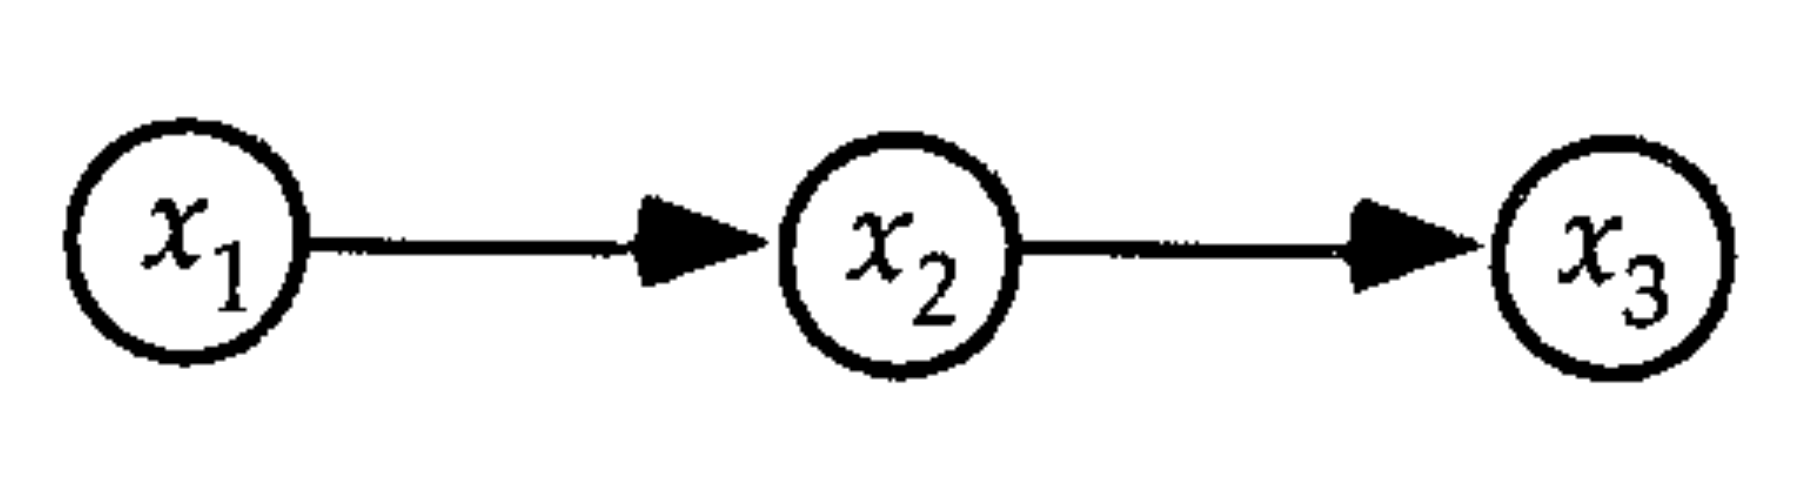

Example of Bp: for each node in a belief-network structure, there is a conditional-probability function that relates 
this node to its immediate predecessors (parents) and if a node has no parents, then a prior-probability function 
is provided.

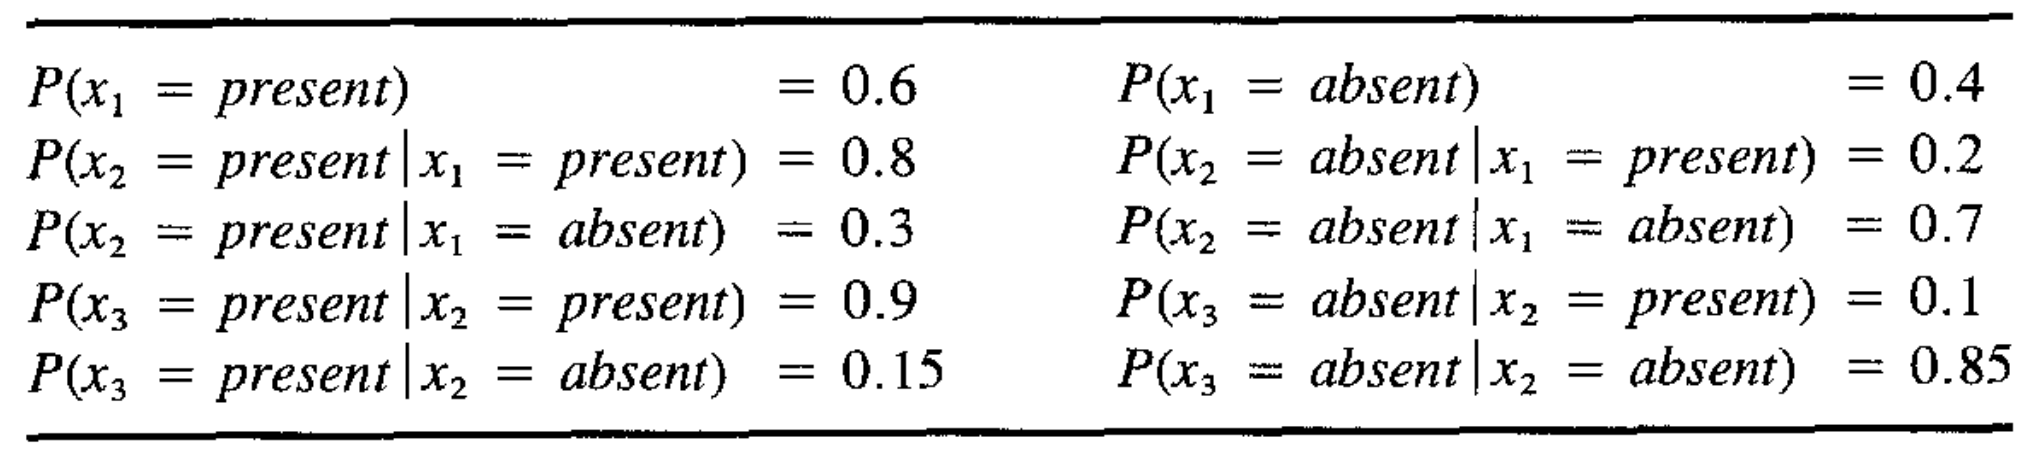

In [3]:
h = 70
cat('Example of Bs')
display_png(file="figures/Belief_network_ex.png", width = 3*h, height =h ) 
cat('Example of Bp: for each node in a belief-network structure, there is a conditional-probability function that relates 
this node to its immediate predecessors (parents) and if a node has no parents, then a prior-probability function 
is provided.')
display_png(file="figures/prob_assignment.png", width = 10*h, height =2*h )  

#### Notation
* $m$: number of cases in D
* $n$: number of variables in D
* $Z = \{x\}_i$, i = 1,..,n set of variables
* $r_i$: number of possible value assigned to $x_i$
* $v_i = \{v_{i1},...,v_{ir_i}\}$ : possible value assignments to $x_i$
* $parents \space of\space x_i$: immediate predecessors of $x_i$
* $\pi_i$: set of parents related to $x_i$
* $q_i$ = number of possible value assigned to $\pi_i$ 
* $w_i = \{ w_{ij}, j = 1,..,r_j\}$ unique instantiation of $\pi_i$ relative to D. 
* $N_{ijk}$: number of cases in D in which variable $x_i$ has the value $v_{ik}$ and $\pi_i$ is instantiated as $w_{ij}$


#### In our problem: 

* $m$ = 10
* $n$ = 3
* $Z$ = {$x_1$, $x_2$, $x_3$}
* $r_1$ = $r_2$ = $r_3$ = 2
* $v_i = (v_{1i},...,v_{ir_i})$ = $(v_{i1},v_{i2})$=(0,1) 
* $q_1$ = $q_2$ = $q_3$ = 2
* $w_i = (w_{i1},...,w_{iq_i})$ = $(w_{i1},w_{i2})$=(0,1) 


## 1 Finding the most probable belief-network structure

We want to find the belief-network structure $B_s$ that maximize $P(B_s|D)$. In general, there may be more than one such structure but we we assume to be just one.

We know that for a generic $B_{s_j}$ structure, over the assumption above, we have:



$P(B_{s_j}| D) = \frac{P(B_{s_j}, D)}{P(D)}$

where $P(D)$ is the sum of $P(B_{s_j}, D)$ over all the possibile belief-network structure $B_s$ that we assume equally likely a priori:  $\sum\limits_{B_{s_j}} P(B_{s_j}, D)$


Thus, finding $B_s$ that maximize the posterior $P(B_s|D)$ is equivalent to find the one that maximize  $P(B_{s_j}, D)$ that can be done just computing 

\begin{equation}
P(B_{s_j}, D) = P(B_s)\prod_{i=1}^{n}\prod_{j=1}^{q_i}\frac{(r_i -1)!}{(N_{ij} + r_i -1)!}\prod_{k=1}^{r_i}N_{ijk}!
\end{equation}

for every possibile $B_s$ that mean that, given n variables we have to compute $P(B_{s_j}, D)$   $2^{\frac{n(n-1)}{2}}$ times, therefore the time complexity is $O(m n^2 r 2^n)$
that should be computational demanding for bigger datasets so we will implement an heuristic method instead.

### K2 algorithm

We use an algorithm that begins by making the assumption that a node has no parents, and then adds incrementally that parent whose addition most increases the probability of the resulting structure.When the addition of no single parent can increase the probability, we stop adding parents to the node.
To compute
We also shall use a function Pred(xi) that returns the set of nodes that precede xi in the node ordering.

Time complexity: $O(m \times u \times r)$

In [66]:
score <- function(x.i, pi.i){
    '
    Function to compute the score: it represents the probability of the 
    database D given that the parents of x.i are pi.i

    Inputs:
        - x.i: list containing the i-th node of the database
        - pi.i: list of parents of node x.i

    Output:
        - probability of database given pi.i as parents of x.i
    '
    r.i <- length(unique(unlist(x.i)))
    # case without parents
    if(length(pi.i)==0){
        alpha <- table(x.i)
        N     <- sum(alpha)
        prob  <- factorial(r.i-1)/factorial(N+r.i-1)*prod(sapply(alpha,factorial))
    }

    # standard version with parents
    else{
        data  <- cbind(x.i,pi.i)
        alpha <- table(data)
        # recast in a matrix
        if (length(dim(alpha))>2){dim(alpha)<-c(r.i,length(alpha)/r.i)}
        # transpose
        alpha<-t(alpha)
        N.j <- rowSums(alpha)
        M.j <- apply(apply(alpha, c(1,2), factorial),1,prod)
        prob <- prod(apply(cbind(N.j,M.j),1, function(x) x[2]*factorial(r.i-1)/factorial(x[1] + r.i - 1)))
    }
    return(prob)
}

In [94]:
score.log <- function(x.i, pi.i){
    '
    Function to compute the score: it represents the probability of the 
    database D given that the parents of x.i are pi.i

    Inputs:
        - x.i: list containing the i-th node of the database
        - pi.i: list of parents of node x.i

    Output:
        - probability of database given pi.i as parents of x.i
    '
    r.i <- length(unique(unlist(x.i)))
    # case without parents
    if(length(pi.i)==0){
        alpha <- table(x.i)
        N     <- sum(alpha)
        prob  <- lfactorial(r.i-1)-lfactorial(N+r.i-1)+sum(sapply(alpha,lfactorial))
    }

    # standard version with parents
    else{
        data  <- cbind(x.i,pi.i)
        alpha <- table(data)
        # recast in a matrix
        if (length(dim(alpha))>2){dim(alpha)<-c(r.i,length(alpha)/r.i)}
        # transpose
        alpha<-t(alpha)
        N.j <- rowSums(alpha)
        M.j <- apply(apply(alpha, c(1,2), lfactorial),1,sum)
        prob <- sum(apply(cbind(N.j,M.j),1, function(x) x[2]+lfactorial(r.i-1)-lfactorial(x[1] + r.i - 1)))
    }
    return(prob)
}


  Bayesian network parameters

  Parameters of node x1 (multinomial distribution)

Conditional probability table:
   0   1 
0.5 0.5 

  Parameters of node x2 (multinomial distribution)

Conditional probability table:
 
   x1
x2          0         1
  0 0.7727273 0.2272727
  1 0.2272727 0.7727273

  Parameters of node x3 (multinomial distribution)

Conditional probability table:
 
   x2
x3           0          1
  0 0.77272727 0.04545455
  1 0.22727273 0.95454545



$score
[1] -19.92268

$dag

  Random/Generated Bayesian network

  model:
   [x1][x2|x1][x3|x2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 



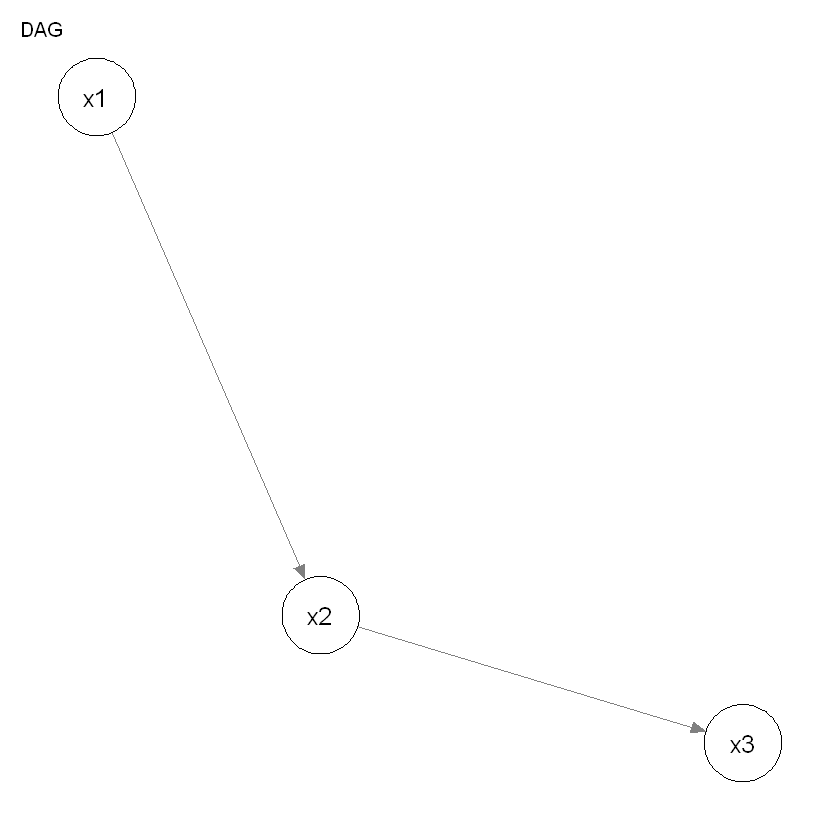

In [186]:
K2 <- function(data, order=c(1,2,3), max.parents=3, 
               cases.column=TRUE, f=score, 
               output.prob=TRUE, output.graph=TRUE) {
    '
    K2 algorithm to learn the topology of a Bayesian Network.

    Input:
        - data: data.frame with n+1 columns (the first one is the case column)
        - order: vector with the ordering of the nodes in data
        - max.parents: upper bound on the number of parents a node may have
        - cases.column: boolean, true if the dataframe has the column cases
        - f: function to call as score function: [score, score.log]
        - output.prob: boolean, true if you want to output the probabilities
    Output:
        - list with first element the score and second element the dag
    '
    # select columns in the right order
    if(cases.column){
        nodes       <- data[, order+1]
    }
    else{
        nodes       <- data[, order]
    }
    
    # number of nodes
    n           <- length(nodes)
    
    output.list <- list()
    g.nodes     <- names(nodes)
    dag         <- empty.graph(nodes=g.nodes)
    k2.score    <- 0

    for( i in 1:n ){
        # empty vector to store the parents of each node
        parents <- character()
        p.old   <- f(nodes[i], nodes[parents])
        ok.to.proceed <- TRUE
        pred_xi <- g.nodes[1:i-1]

        while(ok.to.proceed & length(parents)<max.parents){
            # create a list with the possible parent nodes to inspect
            unions      <- lapply(setdiff(pred_xi, parents), union, parents)
            
            new.parents <- unlist(unions[which.max(sapply(unions, function(x) f(nodes[i], nodes[x])))])
            p.new       <- f(nodes[i], nodes[new.parents])        

            if(p.new > p.old){
                p.old   <- p.new
                parents <- new.parents
                
                for (p in new.parents){
                    dag <- set.arc(dag, from=p, to=g.nodes[i])
                }
            }
            else{
                ok.to.proceed <- FALSE
            }
        }
        k2.score <- k2.score + p.old
    }
    
    if (output.prob){
        if(cases.column){
            set <- data.frame(apply(data[2:ncol(data)],c(1,2),as.character), stringsAsFactors = TRUE)
        }
        else{
            set <- data.frame(apply(data[1:ncol(data)],c(1,2),as.character), stringsAsFactors = TRUE)
        }
        print(bn.fit(dag, data = set, method = 'bayes'))
    }
    if(output.graph){
        qgraph(dag, nodeNames = g.nodes, layout = "spring",
               legend=FALSE, theme = "colorblind", title = "DAG")
    }

    output.list["score"] <- k2.score
    output.list["dag"] <- list(dag)
    return(output.list)
}

#network<-K2(D, output.prob=FALSE)
#network
                                                          

network<-K2(D, f=score.log, output.prob=TRUE)
network

Due to its structure, the algorithm is sensitive to the initial ordering given as input, for completeness we report below the results obtained for each combination of the 3 variables

In [173]:
comb.scores <- function(data, from=1, to=3){
    orders <- permn(1:3)
    scores <- list()

    for(i in seq_along(orders)){
        scores[i] <- K2(data, order = unlist(orders[i], use.names=FALSE), f=score.log,output.prob = FALSE)$score
    }

    names(scores) <- sapply(orders, paste0, collapse="")
    return(as.data.frame(scores))
}

comb.scores(D)

X123,X132,X312,X321,X231,X213
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-19.92268,-20.76997,-20.7418,-19.89451,-19.92268,-19.92268


## 2 Usage of bnstruct for the analysis

In [174]:
data <- D[2:4]
data.BND <- BNDataset(data = data,
                      discreteness = rep('d', ncol(data)),
                      variables = names(data),
                      node.sizes = c(2,2,2),
                      starts.from = 0)
data.BND <- bootstrap(data.BND, num.boots=100, imputation=TRUE)
show(data.BND)


bnet <- learn.network(data.BND, layering = c(1,2,3), scoring.func='k2', algo='hc')
print(bnet)

bnstruct :: Generating bootstrap samples with imputation ...

bnstruct :: Bootstrap samples generated.




Dataset: 

num.variables 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
num.items
10
imputation
FALSE
has.boots
TRUE
has.imputed.boots
TRUE
num.boots
100


bnstruct :: scoring function not recognized, using BDeu

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
   x3
x2           1         2
  1 0.77272727 0.2272727
  2 0.04545455 0.9545455




In [175]:
options(max.print = 200, width = 60)

raw.data(data.BND)

x1,x2,x3
2,1,1
2,2,2
1,1,2
2,2,2
1,1,1
1,2,2
2,2,2
1,1,1
2,2,2
1,1,1


[1] ""

$x1
 [1] 2 2 1 2 1 1 2 1 2 1

$x2
 [1] 1 2 1 2 1 2 2 1 2 1

$x3
 [1] 1 2 2 2 1 2 2 1 2 1

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  0  0
x2  1  0  0
x3  0  1  0

Conditional probability tables:[[1]]
NULL



bnstruct :: scoring function not recognized, using BDeu

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  0  0
x2  1  0  0
x3  0  1  0

Conditional probability tables:$x1
   x1
x2          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x2
   x2
x3          1          2
  1 0.9444444 0.05555556
  2 0.1923077 0.80769231

$x3
x3
        1         2 
0.4090909 0.5909091 



0,0,0
1,0,0
0,1,0


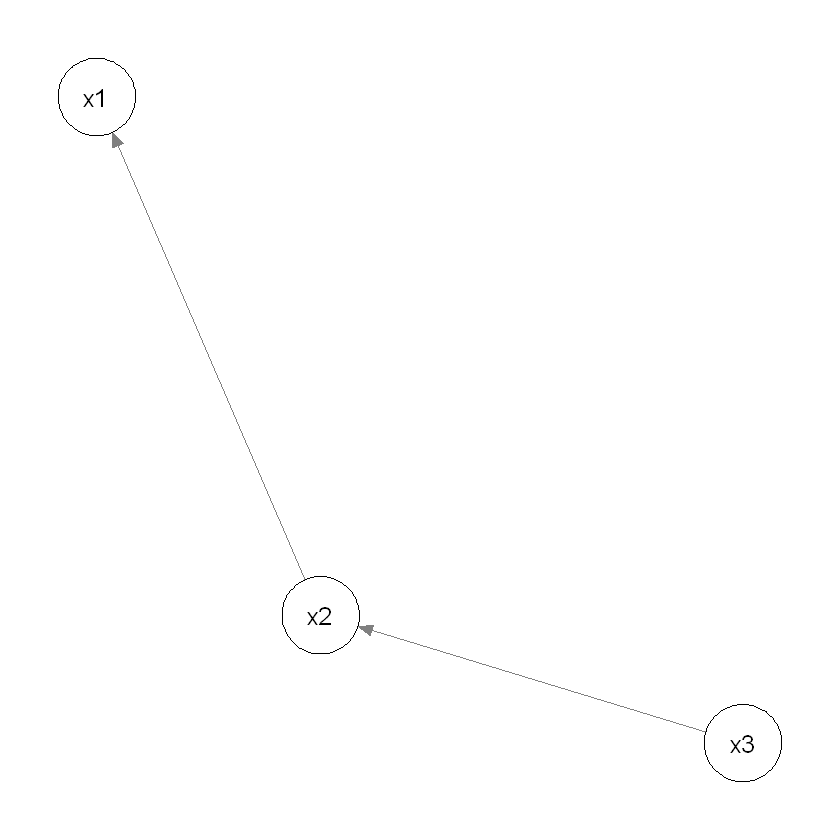

In [176]:
# bayesian network object with no structure nor parameters
net <- BN(data.BND)
scoring.func(net)
as.list(as.data.frame(raw.data(data.BND)))
learn.structure(bn = net, dataset = data.BND)
net <- learn.network(data.BND, algorithm='k2', scoring.func="k2")
net

dag(net)
plot(net, method='qgraph')

In [177]:
# don't know how to order the BN object

setGeneric("learn.network.custom", function(x, algo='K2', scoring.func='default', 
                                            order=c(1,2,3), max.parents=2, f=score,initial.network=NULL) 
standardGeneric("learn.network.custom") )


#' @rdname learn.network.custom
#' @aliases learn.network.custom,BNDataset
setMethod("learn.network.custom",
          c("BNDataset"),
          function(x, algo='K2', scoring.func='default', 
                   order=c(1,2,3), max.parents=2, f=score,
                   initial.network=NULL){
              dataset <- x
              bn <- BN(dataset)
              
              # setup
              num.nodes(bn)  <- num.variables(dataset)
              node.sizes(bn) <- node.sizes(dataset)
              variables(bn)  <- variables(dataset)
              validObject(bn)

              node.sizes <- node.sizes(bn)
              num.nodes  <- num.nodes(bn)

#              if (length(cont.nodes) == 0)
#                  cont.nodes <- setdiff(1:num.nodes,which(discreteness(dataset)))

              # get data
#              if (bootstrap){
#                  if (!has.boots(dataset))
#                      stop("Bootstrap samples not available. Please generate samples before learning with bootstrap.\nSee > ?bootstrap for help.")

#                  if (use.imputed.data && !has.imputed.boots(dataset))
#                      stop("Imputed samples not available. Please generate imputed samples before learning.\nSee > ?bootstrap for help.")

#                  num.boots <- num.boots(dataset)
#              }
#              else{
                  # not bootstrap (default)
#                  if (use.imputed.data && has.imputed.data(dataset))
#                      data   <- imputed.data(dataset)
#                  else if (use.imputed.data && !has.imputed.data(dataset))
#                      stop("Imputed data not available. Please impute data before learning.\nSee > ?impute for help.")
#                  else
#                      data <- raw.data(dataset)
#              }
              
#              # in case of future develpments
#              scoring.func <- match(tolower(scoring.func), c("default"))
#              if (is.na(scoring.func)){
#                  bnstruct.log("scoring function not recognized, using default")
#                  scoring.func <- 0
#              }
#              else {
#                  scoring.func <- scoring.func - 1
#              }
#              
#              scoring.func(bn) <- c("DEFAULT")[scoring.func + 1]
#              
#              algo <- tolower(algo)
#              if (!algo %in% c("k2")) {
#                  bnstruct.log("structure learning algorithm not recognized, using k2")
#                  bnstruct.log("(available options are: K2)")
#                  algo <- "K2"
#              }

              
              # get initial.network
              if (!is.null(initial.network)){
                  if (inherits(initial.network, "BN"))
                      init.net <- initial.network
                  else if (inherits(initial.network, "matrix")){
                    init.net      <- BN(dataset)
                    dag(init.net) <- initial.network
                    init.net      <- learn.params(init.net, dataset)
                  }
                  else if (inherits(initial.network, "character") &&
                           tolower(initial.network) == "random.chain")
                      init.net <- sample.chain(dataset)
                  else # string != "random.chain"
                      init.net <- NULL
                  if (!is.null(init.net))
                      validObject(init.net)
              }
              else
                  init.net <- NULL
              
              
              
              # select columns in the right order
              nodes <- as.data.frame(raw.data(data.BND))
              
              # number of nodes
              n <- length(nodes)

              # empty vector to store the parents of each node
              parents <- rep(NULL, 0)
    
              g.nodes <- names(nodes)
    
              dag.matrix <- matrix(0, nrow=n, ncol=n)

              for( i in 1:n ){
                  # empty vector to store the parents of each node
                  parents <- character()
                  p.old   <- f(nodes[i], nodes[parents])
                  ok.to.proceed <- TRUE
                  pred_xi <- g.nodes[1:i-1]

                  while(ok.to.proceed & length(parents)<max.parents){
                      # create a list with the possible parent nodes to inspect
                      unions      <- lapply(setdiff(pred_xi, parents), union, parents)

                      new.parents <- unlist(unions[which.max(sapply(unions, function(x) f(nodes[i], nodes[x])))])
                      p.new       <- f(nodes[i], nodes[new.parents])

                      if(p.new > p.old){
                          p.old   <- p.new
                          parents <- new.parents
                      }
                      else{
                          ok.to.proceed <- FALSE
                      }
                  }
                  for (p in parents){
                      row <- grep(p, g.nodes)
                      dag.matrix[row, i] <- 1
                  }
              }
              dag(bn) <- dag.matrix
              bn <- learn.params(bn, dataset)
              return(bn)
          })

[1] "learn.network.custom"

bnstruct :: Generating bootstrap samples with imputation ...

bnstruct :: Bootstrap samples generated.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Bayesian Network: BNDataset

num.nodes 3

variables
x1 x2 x3
discreteness
TRUE TRUE TRUE
node.sizes
2 2 2
Adjacency matrix:
   x1 x2 x3
x1  0  1  0
x2  0  0  1
x3  0  0  0

Conditional probability tables:$x1
x1
  1   2 
0.5 0.5 

$x2
   x2
x1          1         2
  1 0.7727273 0.2272727
  2 0.2272727 0.7727273

$x3
   x3
x2           1         2
  1 0.77272727 0.2272727
  2 0.04545455 0.9545455




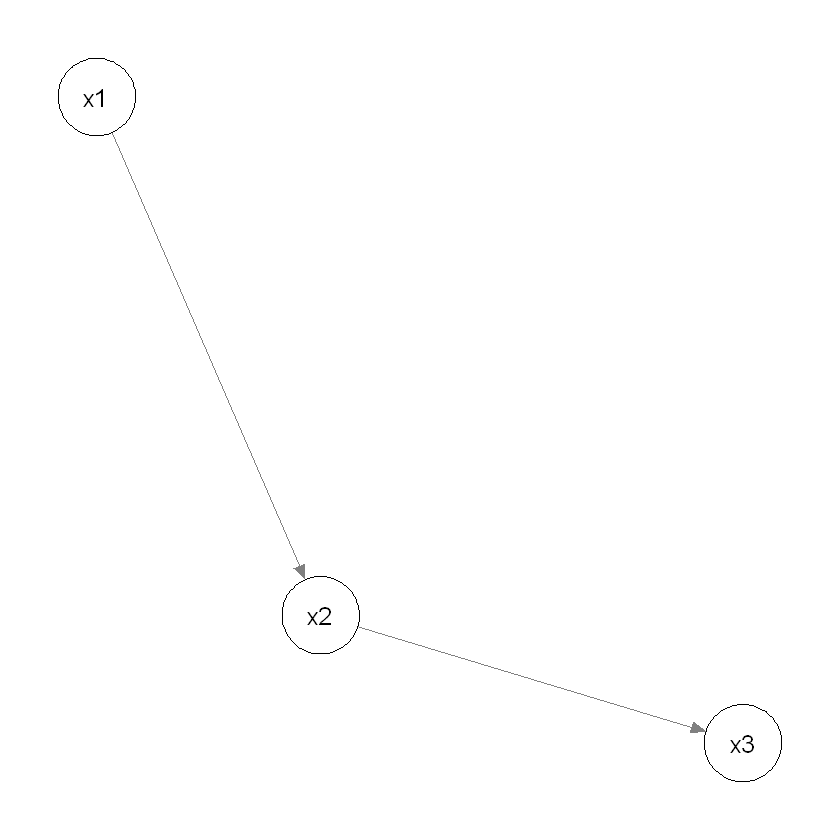

In [178]:
data.BND <- BNDataset(data = data,
                discreteness = rep('d', ncol(data)),
                variables = names(data),
                node.sizes = c(2,2,2),
                starts.from = 0)
data.BND <- bootstrap(data.BND, num.boots=100, imputation=TRUE)

bnet <- learn.network.custom(data.BND, scoring.func='default', algo='K2')
print(bnet)
plot(bnet, method = 'qgraph')


### 2.1 Analyse bnstruct with missing data 
A dataset may contain various kinds of missing data, namely unobserved variables, and unobserved values for otherwise observed variables. We currently
deal only with this second kind of missing data. The process of guessing the
missing values is called imputation.
We provide the impute function to perform imputation.

Imputation is accomplished with the k-Nearest Neighbour algorithm. The
number of neighbours to be used can be chosen specifying the k.impute parameter (default is k.impute = 10). Given that the parameter is highly datasetdependant, we also include the tune.knn.impute function to assist the user
while choosing the best value for k.

Parameter learning is the operation that learns the conditional probabilities
entailed by a network, given the data and the structure of the network. In
bnstruct this is done by learn.network performing a Maximum-A-Posteriori
(MAP) estimate of the parameters. It is possible to choose if using the raw
or the impute dataset (use.imputed.data parameter), and to configure the
Equivalent Sample Size (ess parameter).

In [179]:
dataset <- child()
dataset <- impute(dataset)
Child   <- as.data.frame(imputed.data(dataset))
names(Child) <- variables(child())

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



bnstruct :: performing imputation ...

bnstruct :: imputation finished.

bnstruct :: scoring function not recognized, using BDeu

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



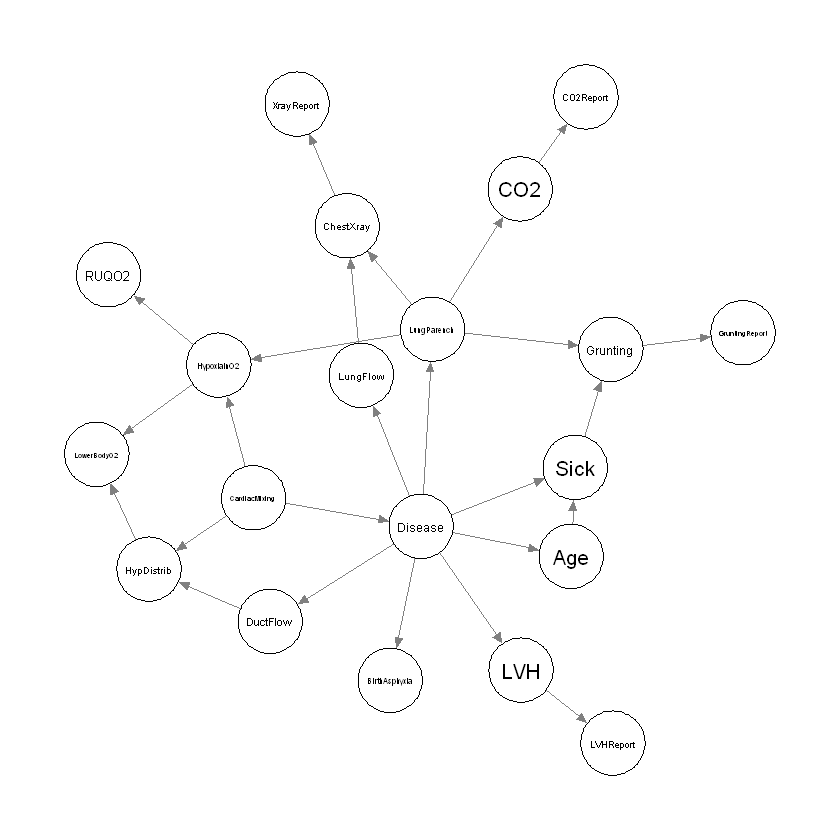

In [180]:
# learning with imputed data,
imp.dataset <- impute(dataset)
net  <- learn.network(imp.dataset, 
                      use.imputed.data = TRUE, 
                      algorithm = 'K2',
                      scoring.func = 'k2')

#net <- learn.network.custom(imp.dataset, scoring.func='K2')#, algo='default')

plot(net, method="qgraph")


  Bayesian network parameters

  Parameters of node BirthAsphyxia (multinomial distribution)

Conditional probability table:
         1         2 
0.0854829 0.9145171 

  Parameters of node Disease (multinomial distribution)

Conditional probability table:
 
       BirthAsphyxia
Disease          1          2
      1 0.22241715 0.02625633
      2 0.28557505 0.33674064
      3 0.25516569 0.31137714
      4 0.14522417 0.22894574
      5 0.04931774 0.04877738
      6 0.04230019 0.04790277

  Parameters of node Age (multinomial distribution)

Conditional probability table:
 
   Disease
Age          1          2          3          4          5
  1 0.90653240 0.75567365 0.35094394 0.80425745 0.83572241
  2 0.07461916 0.16126876 0.20549335 0.13889306 0.11080774
  3 0.01884844 0.08305759 0.44356271 0.05684949 0.05346985
   Disease
Age          6
  1 0.88147107
  2 0.09299602
  3 0.02553291

  Parameters of node LVH (multinomial distribution)

Conditional probability table:
 
   Disease
LVH   

$score
[1] -59645.12

$dag

  Random/Generated Bayesian network

  model:
   [BirthAsphyxia][Disease|BirthAsphyxia][Age|Disease]
   [LVH|Disease][DuctFlow|Disease][CardiacMixing|Disease]
   [LungParench|Disease][LungFlow|Disease][Sick|Disease:Age]
   [HypDistrib|DuctFlow:CardiacMixing]
   [HypoxiaInO2|CardiacMixing:LungParench][CO2|LungParench]
   [ChestXray|LungParench:LungFlow][LVHReport|Disease:LVH]
   [Grunting|LungParench:Sick]
   [LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2]
   [CO2Report|CO2][XrayReport|ChestXray]
   [GruntingReport|Grunting]
  nodes:                                 20 
  arcs:                                  26 
    undirected arcs:                     0 
    directed arcs:                       26 
  average markov blanket size:           3.10 
  average neighbourhood size:            2.60 
  average branching factor:              1.30 

  generation algorithm:                  Empty 



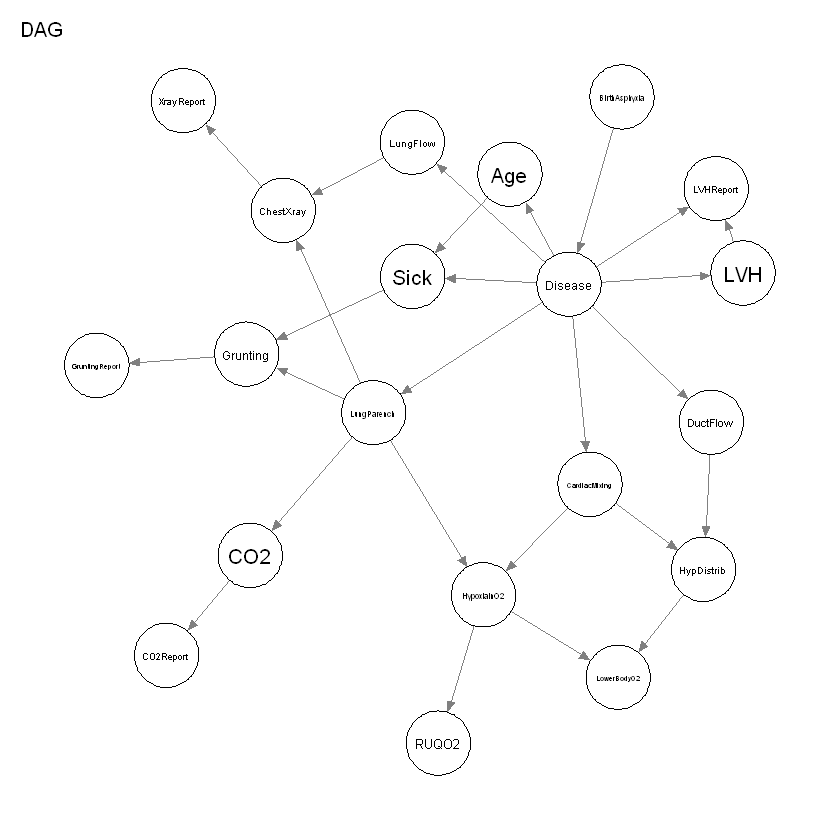

In [181]:
K2(data = as.data.frame(Child), order = c(1:20), max.parent=2, cases.column=FALSE, f=score.log,output.prob=TRUE)

In [504]:
# To retrieve the parameters
cpts(net)

$BirthAsphyxia
       BirthAsphyxia
Disease          1         2
      1 0.44190550 0.5580945
      2 0.07344831 0.9265517
      3 0.07114904 0.9288510
      4 0.05597295 0.9440270
      5 0.08634812 0.9136519
      6 0.07624736 0.9237526

$Disease
           Disease
LungParench          1         2         3         4
          1 0.03541723 0.3705222 0.3345795 0.2481008
          2 0.06162824 0.1820381 0.1282380 0.1384856
          3 0.06597095 0.2417307 0.2691932 0.1505554
           Disease
LungParench           5           6
          1 0.007041408 0.004338948
          2 0.374181611 0.115428409
          3 0.079152935 0.193396802

$Age
, , Age = 1

       Sick
Disease         1         2
      1 0.9298651 0.8947777
      2 0.8313405 0.7285095
      3 0.7385085 0.2702957
      4 0.8376958 0.7920809
      5 0.8505906 0.7930427
      6 0.9398171 0.7423702

, , Age = 2

       Sick
Disease          1          2
      1 0.05587669 0.08406135
      2 0.11621434 0.17744317
      3 0.10613232 0.22616937
      4 0.11492635 0.14762051
      5 0.10507747 0.12725672
      6 0.05403159 0.18588981

, , Age = 3

       Sick
Disease           1          2
      1 0.014258189 0.02116094
      2 0.052445119 0.09404738
      3 0.155359209 0.50353492
      4 0.047377803 0.06029859
      5 0.044331953 0.07970057
      6 0.006151288 0.07173999


$LVH
       LVH
Disease          1         2
      1 0.07010070 0.9298993
      2 0.09089542 0.9091046
      3 0.07701924 0.9229808
      4 0.89624343 0.1037566
      5 0.04539249 0.9546075
      6 0.10997892 0.8900211

$DuctFlow
       DuctFlow
Disease         1           2            3
      1 0.1629228 0.056028918 0.7810482830
      2 0.0932852 0.817039340 0.0896754571
      3 0.8199080 0.174185600 0.0059064391
      4 0.9953919 0.003656399 0.0009516654
      5 0.3934016 0.278725825 0.3278725825
      6 0.1815413 0.375497775 0.4429608808

$CardiacMixing
       CardiacMixing
Disease           1          2          3          4
      1 0.395236251 0.40917893 0.17215337 0.02343145
      2 0.022886794 0.07402487 0.09207360 0.81101474
      3 0.013724318 0.13243287 0.82642135 0.02742146
      4 0.007250188 0.01716754 0.95480841 0.02077385
      5 0.012457338 0.02474403 0.94624573 0.01655290
      6 0.362789881 0.52723120 0.08028812 0.02969079

$LungParench
LungParench
         1          2          3 
0.73991868 0.07805106 0.18203026 

$LungFlow
       LungFlow
Disease          1          2          3
      1 0.26052156 0.69739220 0.04208624
      2 0.18533373 0.04696013 0.76770614
      3 0.12526724 0.82251694 0.05221582
      4 0.07307789 0.88449787 0.04242424
      5 0.25005688 0.11490330 0.63503982
      6 0.67908175 0.10142891 0.21948934

$Sick
       Sick
Disease         1         2
      1 0.3350116 0.6649884
      2 0.2641632 0.7358368
      3 0.1722470 0.8277530
      4 0.2669421 0.7330579
      5 0.7416382 0.2583618
      6 0.7044975 0.2955025

$HypDistrib
, , HypDistrib = 1

        CardiacMixing
DuctFlow          1         2         3         4
       1 0.94270016 0.9485582 0.9591123 0.9668493
       2 0.97127784 0.9613272 0.9693661 0.9513562
       3 0.06014235 0.4527293 0.9832765 0.5439707

, , HypDistrib = 2

        CardiacMixing
DuctFlow          1          2          3          4
       1 0.05729984 0.05144179 0.04088772 0.03315068
       2 0.02872216 0.03867277 0.03063388 0.04864376
       3 0.93985765 0.54727068 0.01672355 0.45602931


$HypoxiaInO2
, , HypoxiaInO2 = 1

             LungParench
CardiacMixing          1          2          3
            1 0.83572241 0.20725883 0.53314832
            2 0.07608607 0.10910187 0.07966556
            3 0.09334954 0.01911097 0.08748988
            4 0.02122647 0.09653333 0.04052728

, , HypoxiaInO2 = 2

             LungParench
CardiacMixing          1         2         3
            1 0.09852105 0.7230181 0.3111317
            2 0.81274868 0.7383966 0.6589367
            3 0.73357640 0.6766973 0.5179027
            4 0.16710250 0.1541333 0.1

In [514]:
# update the probabilities with EM from the raw dataset,
# starting from the first network
engine <- InferenceEngine(net)
results <- em(engine, dataset)
updated.engine <- results$InferenceEngine
updated.dataset <- results$BNDataset

Warning message in get.adjacency(ig.mst, type = "both", attr = NULL, edges = FALSE):
“The `edges` argument of `as_adjacency_matrix` is deprecated; it will be removed in igraph 1.4.0”
... ... bnstruct :: starting EM algorithm ...

... ... ... bnstruct :: learning network parameters ... 

... ... ... bnstruct :: parameter learning done.

Warning message in get.adjacency(ig.mst, type = "both", attr = NULL, edges = FALSE):
“The `edges` argument of `as_adjacency_matrix` is deprecated; it will be removed in igraph 1.4.0”
... ... ... bnstruct :: learning network parameters ... 

... ... ... bnstruct :: parameter learning done.

... ... ... bnstruct :: learning network parameters ... 

... ... ... bnstruct :: parameter learning done.

Warning message in get.adjacency(ig.mst, type = "both", attr = NULL, edges = FALSE):
“The `edges` argument of `as_adjacency_matrix` is deprecated; it will be removed in igraph 1.4.0”
... ... ... bnstruct :: learning network parameters ... 

... ... ... bnstruct :

In [516]:
engine
#results
#updated.engine
#updated.dataset


Junction Tree with 17 cliques 
 ( 1,2) ( 4,15) ( 2,4) ( 12,18) ( 7,12) ( 11,17) ( 13,19) ( 14,20) ( 2,7,8) ( 7,8,13) ( 10,11,16) ( 2,3,9) ( 7,9,14) ( 2,7,9) ( 2,5,6,10) ( 2,6,7,11) ( 2,6,10,11) 

Adjacency matrix:
             ( 1,2) ( 4,15) ( 2,4) ( 12,18) ( 7,12)
( 1,2)            0       0      0        0       0
( 4,15)           0       0      1        0       0
( 2,4)            0       1      0        0       0
( 12,18)          0       0      0        0       1
( 7,12)           0       0      0        1       0
( 11,17)          0       0      0        0       0
( 13,19)          0       0      0        0       0
( 14,20)          0       0      0        0       0
( 2,7,8)          0       0      1        0       1
( 7,8,13)         0       0      0        0       0
( 10,11,16)       0       0      0        0       0
             ( 11,17) ( 13,19) ( 14,20) ( 2,7,8) ( 7,8,13)
( 1,2)              0        0        0        0         0
( 4,15)             0        0        0    

### 2.2 ALARM

In [191]:
# CORRECT DAG
data(alarm)
modelstring = paste0("[HIST|LVF][CVP|LVV][PCWP|LVV][HYP][LVV|HYP:LVF][LVF]",
  "[STKV|HYP:LVF][ERLO][HRBP|ERLO:HR][HREK|ERCA:HR][ERCA][HRSA|ERCA:HR][ANES]",
  "[APL][TPR|APL][ECO2|ACO2:VLNG][KINK][MINV|INT:VLNG][FIO2][PVS|FIO2:VALV]",
  "[SAO2|PVS:SHNT][PAP|PMB][PMB][SHNT|INT:PMB][INT][PRSS|INT:KINK:VTUB][DISC]",
  "[MVS][VMCH|MVS][VTUB|DISC:VMCH][VLNG|INT:KINK:VTUB][VALV|INT:VLNG]",
  "[ACO2|VALV][CCHL|ACO2:ANES:SAO2:TPR][HR|CCHL][CO|HR:STKV][BP|CO:TPR]")
dag = model2network(modelstring)

[1] "ACO2" "ANES" "APL"  "BP"   "CCHL" "CO"   "CVP"  "DISC"
 [9] "ECO2" "ERCA" "ERLO" "FIO2" "HIST" "HR"   "HRBP" "HREK"
[17] "HRSA" "HYP"  "INT"  "KINK" "LVF"  "LVV"  "MINV" "MVS" 
[25] "PAP"  "PCWP" "PMB"  "PRSS" "PVS"  "SAO2" "SHNT" "STKV"
[33] "TPR"  "VALV" "VLNG" "VMCH" "VTUB"

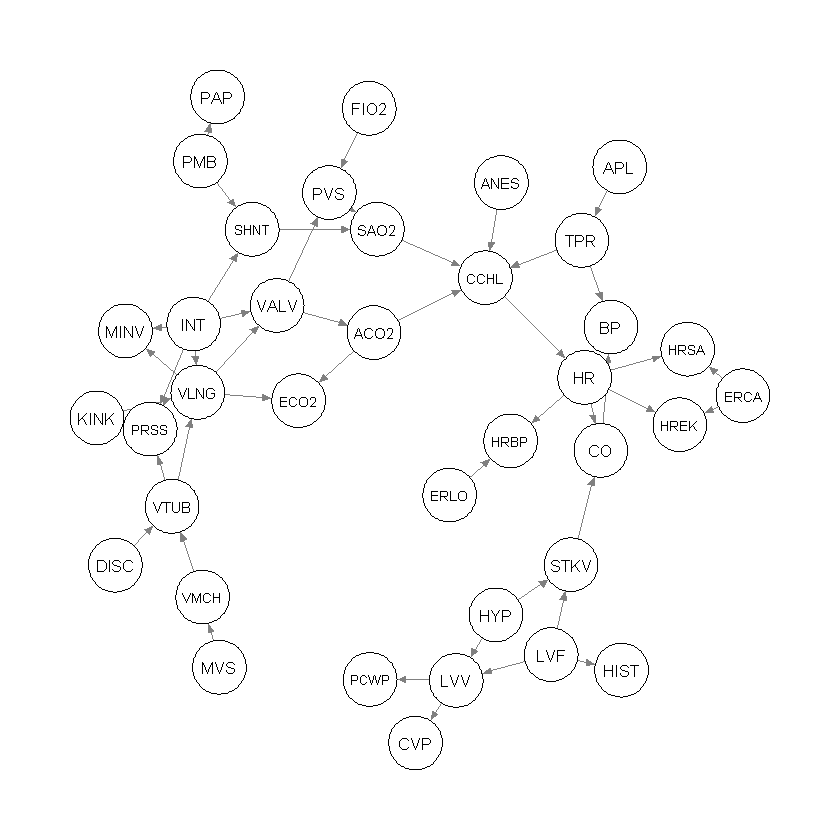

In [193]:
qgraph(dag, nodeNames = names(dag$nodes), legend=FALSE)

$score
[1] -226210.8

$dag

  Random/Generated Bayesian network

  model:
   [CVP][TPR][PAP][ANES][PCWP|CVP][APL|TPR][HIST|CVP:PCWP]
   [BP|PCWP:HIST:TPR][CO|PCWP:HIST:TPR:BP][HRBP|HIST:TPR:CO]
   [HYP|CVP:PCWP:CO][LVF|PCWP:HIST:CO][HREK|TPR:CO:HRBP]
   [SAO2|TPR:HRBP][LVV|CVP:PCWP:HYP:LVF][HRSA|CO:HRBP:HREK]
   [FIO2|SAO2][PRSS|SAO2][PMB|PAP:SAO2]
   [STKV|CO:HRBP:LVF:LVV][ECO2|SAO2:FIO2:PRSS]
   [CCHL|TPR:HRBP:HREK:HRSA][HR|CO:HRBP:HREK:STKV]
   [MINV|SAO2:PRSS:ECO2][ERLO|CO:HRBP:HREK:CCHL]
   [ERCA|HREK:HRSA:HR][MVS|PRSS:ECO2:MINV]
   [INT|PRSS:ECO2:MINV][KINK|PRSS:MINV:INT]
   [DISC|PRSS:MINV:MVS:INT][SHNT|SAO2:MINV:PMB:INT]
   [PVS|SAO2:MINV:INT:SHNT][VTUB|PRSS:MINV:MVS:DISC]
   [ACO2|ECO2:MINV:INT:PVS][VALV|ECO2:MINV:INT:PVS]
   [VMCH|MVS:DISC:VTUB][VLNG|ECO2:INT:ACO2:VALV]
  nodes:                                 37 
  arcs:                                  101 
    undirected arcs:                     0 
    directed arcs:                       101 
  average markov blanket siz

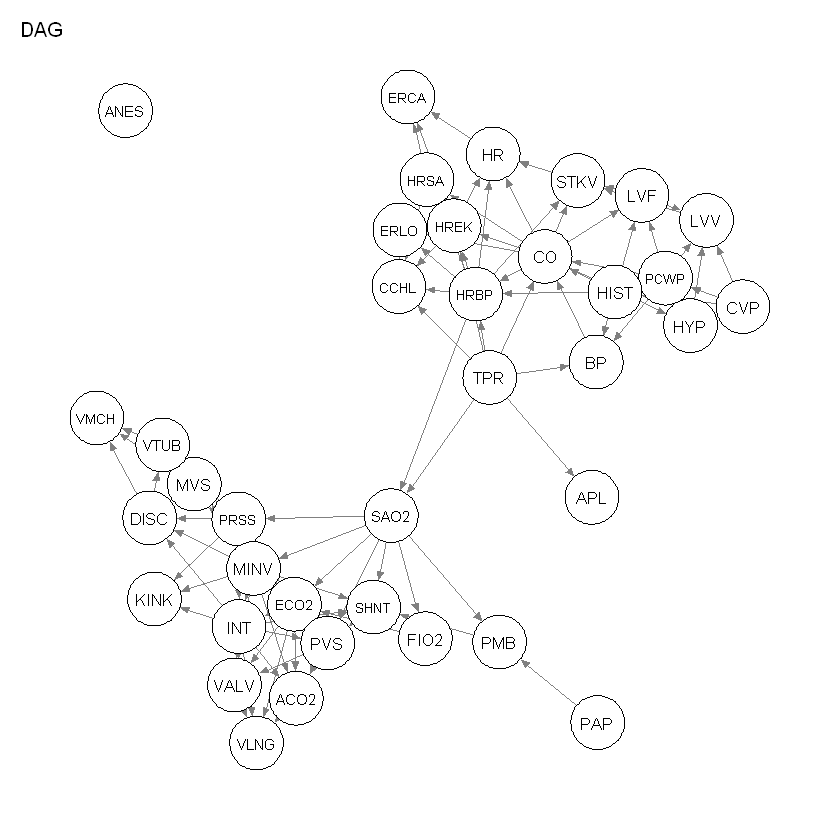

In [196]:
alarm <- as.data.frame(alarm)
K2(data = alarm, order = c(1:length(alarm)), max.parent=4, cases.column=FALSE, f=score.log,output.prob=FALSE)

## Alternative

In [457]:
f <- function(xi, pi){

    vi <- sort(unique(xi)[ , 1])
    ri <- length(vi)
    
    wi <- c()
    qi <- 0
    for (i in 1:length(pi)){
        wi <- c(wi, sort(unique(pi[i])[, 1]))
        qi <- qi + length(sort(unique(pi[i])[, 1]))
       }
    
    N <- matrix(nrow = ri, ncol = qi)
    f <- 1
    for (i in 1:length(pi)){
        for (j in 1:qi){
            for (k in 1:ri){
                N[row = k, col = j] <- sum(xi == vi[k] & pi[i] == wi[j])
            }
        f <- f*factorial(ri-1)*prod(factorial(N[, col = j]))/factorial(sum(N[, col = j])+ri-1)
        }
    }
    
    return (f)
}


In [458]:
Pred <- function(i){
    if(i >= 2){
        return <- seq(1,i-1)
    }
    }

In [459]:
K2 <- function(n, ord ,u, D) {
    
# Input: A set of n nodes = 3  
#        an ordering on the nodes, (permutation of {1,2,3}) 
#        an upper bound u on the number of parents a node may have (n-1), 
#        a database D containing m cases
# Output: For each node, a printout of the parents of the node.}
    
    Output <- list()
    for (i in 1:n){
        
        pi_i  <- data.frame(dummy <- rep(0, 10)) 
        P_old <- f(D[ord[i]+1], pi_i )
        P_new <- c()

        OKToProceed <- 'True'
        pi          <- list()       # list of parents
        pi[[1]]     <- pi_i  
        P           <- 0            # choosen parent
        z           <- ord[Pred(i)] # index of the predecessors
        
        while (OKToProceed == 'True' & (length(pi)) < u ){
            
            if(length(z) >= 1){
                # Get all combinations of the possible parents
                comb <- unlist(lapply(1:length(z),   
                        combinat::combn, 
                        x = z,
                        simplify = FALSE), 
                        recursive = FALSE)

                for (j in 1:length(z)){
                    pi[[j+1]] <- D[comb[[j]]+1]
                    }
                }
            
            for (k in pi){ P_new <- c(f(D[ord[i]+1],k)) }
            
            if(max(P_new) > P_old){
                    P_old  <- P_new
                    P      <- k[which.max(P_new)]
                    
                }
            else{ OKToProceed <- 'False'}
            
                    Output[[i]] <- c(P_old, P) 
                    
            }
        }
            
   return (Output)
}

In [462]:
ord <-c(1, 3, 2, 4)
K2(4,ord,  2, D)

[[1]]
[1] 0.0003607504 0.0000000000

[[2]]
[[2]][[1]]
[1] 0.0005555556

[[2]]$x1
 [1] 1 1 0 1 0 0 1 0 1 0


[[3]]
[[3]][[1]]
[1] 0.004761905

[[3]]$x3
 [1] 0 1 1 1 0 1 1 0 1 0


[[4]]
[[4]][[1]]
[1] 0.005555556

[[4]]$x2
 [1] 0 1 0 1 0 1 1 0 1 0

  asia tub smoke lung bronc either xray dysp
1   no  no    no   no    no     no   no  yes
2   no  no   yes   no    no     no   no   no
3   no  no    no   no    no     no   no   no
4   no  no   yes   no    no     no   no   no
5   no  no   yes   no   yes     no   no  yes
6   no  no   yes   no    no     no   no   no


asia,smoke,tub,lung,either,bronc,xray,dysp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,1
0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0
0,1,0,0,0,1,0,1
0,1,0,0,0,0,0,0
0,0,0,0,0,1,0,1
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0


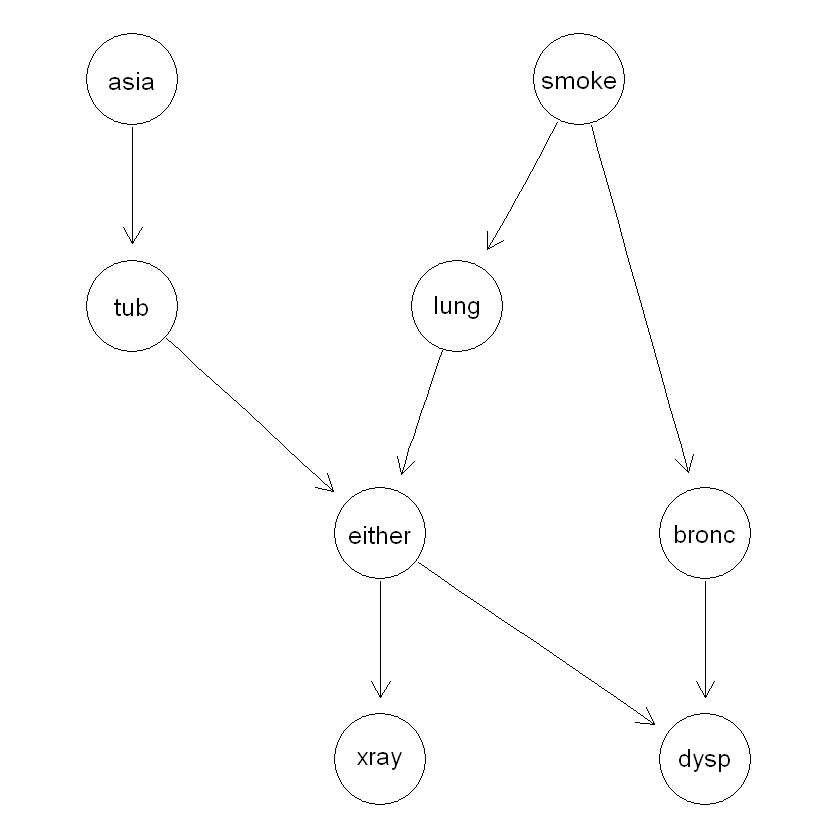

In [101]:
dag <- model2network('[smoke][asia][tub|asia][lung|smoke][bronc|smoke][either|tub:lung][dysp|bronc:either][xray|either]')
graphviz.plot(dag)
dataset <- read.csv('https://www.ccd.pitt.edu//wiki/images/ASIA10k.csv', header=T)
print(head(dataset))

dataset <- ifelse(dataset=='yes',1,0)
col_order <- c('asia', 'smoke', 'tub', 'lung', 'either', 'bronc', 'xray', 'dysp')
dataset <- as.data.frame(dataset[, col_order])
dataset

In [118]:

K2(data=dataset, order=c(1:length(dataset)),max.parents=2,cases.column=FALSE, output.prob=FALSE)

    asia
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     1
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    1
108    1
109    0
110    0
1

ERROR: Error in if (p.new > p.old) {: missing value where TRUE/FALSE needed


In [40]:
(lfactorial(5000))

[1] 37591.14

In [37]:
factorial(10)

[1] 3628800